# Hudson Arney
## Lab 4 - Scapegoat Trees
### CSC 3310 001 - Dr. Berisha

### Introduction: 
In this lab I hope to understand and implement scapegoat trees. I will also get to benchmark certain operations of them to find the optimal alpha value.




### 1a. How do scapegoat trees compare with Red-Black, AVL, and splay trees? Why might you prefer to use or not use a scapegoat tree?

Scapegoat trees are a type of binary search tree that do not store any extra information at each node, unlike Red-Black or AVL trees. They achieve a worst-case search time of O(log n) by occasionally rebuilding subtrees that are too deep or unbalanced. Splay trees are another type of binary search tree that do not store extra information, but they do not guarantee a logarithmic worst-case search time, and they require restructuring during searches.

You may consider using a scapegoat tree for scenarios where a balance between structural efficiency and ease of implementation is preferred.

**Some possible advantages of using scapegoat trees are:**

- They are simple and practical to implement, and do not require complex rotations or color changes.
- They have low storage overhead, since each node only contains a key and two pointers.
- They have fast search performance, especially for search-intensive applications, since they do not incur any balancing overhead during searches.
- They can be easily adapted to other tree-like data structures, such as k-d trees or quad trees, by using relaxed rebuilding routines.

**Some possible disadvantages of using scapegoat trees are:**

- They have slower insertion performance than Red-Black or splay trees, especially for sorted sequences, since they may trigger more rebuilds.
- They have a trade-off between the value of alpha and the performance of different operations. A larger alpha may improve the search and delete times, but worsen the insert time.
- They have a higher constant factor in the amortized update cost than Red-Black or splay trees, since - they need to find the scapegoat node and rebuild the subtree.

### 1b. What does it mean for a node to be weight balanced? What does it mean for a tree to be weight-balanced? Draw some examples and calculate their weight balances.


In the context of Scapegoat Trees, a node is said to be α-weight-balanced if both of its child nodes satisfy the condition **size(child) ≤ α * size(node)**, where size(node) is the size of the subtree rooted at the node and α is a constant between 0.5 and 1. In plain english this means, if the size of each of its subtrees is at most α times the size of the node.

A tree is α-weight-balanced if all the nodes in it are α-weight-balanced. Intuitively, a tree is α-weight-balanced if, for any subtree, the sizes of its left and right subtree are approximately equal.



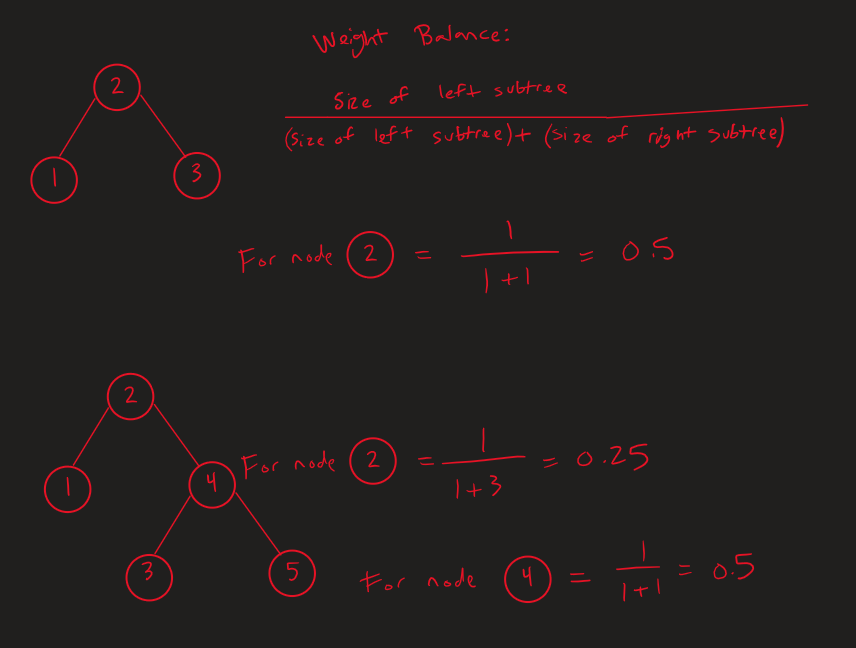

### 1c. What is the interpretation of the α parameter?

α is a parameter that controls the balance between the height and the weight of a scapegoat tree. It affects the performance of the scapegoat tree operations. The authors show that a smaller alpha value leads to faster search and delete operations, but slower insert operations. Conversely, a larger alpha value leads to faster insert operations, but slower search and delete operations. The alpha value should be chosen according to the expected frequency of the operations but was given a recommended value between 0.55 and 0.75.

### 1d. What are the conditions for triggering a rebuild of a subtree (during inserts) or the entire tree (during deletes)?

During **inserts** if the size of the newly inserted node’s parent becomes more than α times the size of the scapegoat tree, the subtree rooted at the scapegoat (the deepest node that is not α-weight-balanced) is rebuilt.

During **deletes** if the size of the tree after the deletion is less than α/2 times the size of the tree before the deletion, the entire tree is rebuilt to ensure that it remains α-weight-balanced.

### 2. Implement a scapegoat tree that supports insert, size, delete, and contains operations.

In [1]:
import unittest
import time
import random
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
class Node:
    def __init__(self, key):
        self.key = key
        self.left = None
        self.right = None

In [3]:
class ScapegoatTree:
    def __init__(self, alpha):
        self.root = None
        self.size = 0
        self.alpha = alpha
        self.rebuild_count = 0

    def size_of_subtree(self, node):
        return 0 if node is None else 1 + self.size_of_subtree(node.left) + self.size_of_subtree(node.right)

    def insert(self, key):
        self.root = self._insert(self.root, key)
        self.size += 1

    def _insert(self, node, key):
        if node is None:
            return Node(key)

        if key < node.key:
            node.left = self._insert(node.left, key)
        elif key > node.key:
            node.right = self._insert(node.right, key)

        if self._is_unbalanced(node):
            self.rebuild_count += 1
            return self._rebuild(node)

        return node

    def _is_unbalanced(self, node):
        if node is None:
            return False

        size_left = self.size_of_subtree(node.left)
        size_right = self.size_of_subtree(node.right)

        return size_left > self.alpha * (size_left + size_right) or size_right > self.alpha * (size_left + size_right)

    def _rebuild(self, node):
        nodes = self._inorder_traversal(node)
        return self._build_tree_from_sorted_nodes(nodes, 0, len(nodes) - 1)

    def _inorder_traversal(self, node):
        result = []
        self._inorder_traversal_recursive(node, result)
        return result

    def _inorder_traversal_recursive(self, node, result):
        if node is not None:
            self._inorder_traversal_recursive(node.left, result)
            result.append(node)
            self._inorder_traversal_recursive(node.right, result)

    def _build_tree_from_sorted_nodes(self, nodes, start, end):
        if start > end:
            return None

        mid = (start + end) // 2
        root = nodes[mid]
        root.left = self._build_tree_from_sorted_nodes(nodes, start, mid - 1)
        root.right = self._build_tree_from_sorted_nodes(nodes, mid + 1, end)

        return root

    def toList(self):
        return [node.key for node in self._inorder_traversal(self.root)]

    def size(self):
        return self.size

    def contains(self, key):
        return self._contains(self.root, key)

    def _contains(self, node, key):
        if node is None:
            return False

        if key == node.key:
            return True
        elif key < node.key:
            return self._contains(node.left, key)
        else:
            return self._contains(node.right, key)

    def delete(self, key):
        if self.contains(key):
            self.root = self._delete(self.root, key)
            self.size -= 1

    def _delete(self, node, key):
        if node is None:
            return None

        if key < node.key:
            node.left = self._delete(node.left, key)
        elif key > node.key:
            node.right = self._delete(node.right, key)
        else:
            if node.left is None:
                return node.right
            elif node.right is None:
                return node.left
            else:
                successor = self._get_min(node.right)
                node.key = successor.key
                node.right = self._delete(node.right, successor.key)

        if self._is_unbalanced(node):
            self.rebuild_count += 1
            return self._rebuild(node)

        return node

    def _get_min(self, node):
        while node.left is not None:
            node = node.left
        return node


### 3. Write unit tests that involve the insert, remove, size, contains, and toList() operations.

In [5]:
class TestScapegoatTree(unittest.TestCase):
    
    def test_insert(self):
        tree = ScapegoatTree(0.75)
        keys = [3, 1, 5, 2, 4]

        for key in keys:
            tree.insert(key)

        self.assertEqual(tree.size, len(keys))
        for key in keys:
            self.assertTrue(tree.contains(key))

    def test_delete(self):
        tree = ScapegoatTree(0.75)
        keys = [3, 1, 5, 2, 4]

        for key in keys:
            tree.insert(key)

        tree.delete(2)
        tree.delete(5)

        self.assertEqual(tree.size, len(keys) - 2)
        self.assertFalse(tree.contains(2))
        self.assertFalse(tree.contains(5))
    
    def test_contains(self):
        tree = ScapegoatTree(0.75)
        keys = [3, 1, 5, 2, 4]
        
        for key in keys:
            tree.insert(key)
            
        keys_to_check = [2, 4, 5]
        for key in keys_to_check:
            self.assertTrue(tree.contains(key))
        
        keys_to_check = [0, 6, 7]
        for key in keys_to_check:
            self.assertFalse(tree.contains(key))

    def test_toList(self):
        tree = ScapegoatTree(0.75)
        keys = [3, 1, 5, 2, 4]

        for key in keys:
            tree.insert(key)

        sorted_keys = sorted(keys)
        self.assertEqual(tree.toList(), sorted_keys)

    def test_empty_tree(self):
        tree = ScapegoatTree(0.75)

        self.assertEqual(tree.size, 0)
        self.assertFalse(tree.contains(1))
        self.assertEqual(tree.toList(), [])


In [6]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestScapegoatTree)

unittest.TextTestRunner().run(suite)

EEEEE
ERROR: test_contains (__main__.TestScapegoatTree.test_contains)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\arneyh\AppData\Local\Temp\ipykernel_19812\321261372.py", line 37, in test_contains
    self.assertTrue(tree.contains(key))
                    ^^^^^^^^^^^^^
AttributeError: 'ScapegoatTree' object has no attribute 'contains'

ERROR: test_delete (__main__.TestScapegoatTree.test_delete)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\arneyh\AppData\Local\Temp\ipykernel_19812\321261372.py", line 22, in test_delete
    tree.delete(5)
  File "C:\Users\arneyh\AppData\Local\Temp\ipykernel_19812\462111449.py", line 186, in delete
    self.rebuild_tree(self.root)
  File "C:\Users\arneyh\AppData\Local\Temp\ipykernel_19812\462111449.py", line 75, in rebuild_tree
    if node.parent is None:
       ^^^^^^^^^^^
AttributeError: 'Node' obj

<unittest.runner.TextTestResult run=5 errors=5 failures=0>

### 4. Benchmark the insert, delete, and contains operations of your implementation on data sets of different sizes. Create tables and plots that include both run times and the number of times the rebuild operation was performed.

In [7]:
def generate_random_data(size):
    return [random.randint(1, 1000) for x in range(size)]

In [8]:
def benchmark_scapegoat_tree(data_sizes, alpha):
    insert_times = []
    delete_times = []
    contains_times = []
    rebuild_counts = []

    for size in data_sizes:
        # Create a new ScapegoatTree instance for each iteration
        scapegoat_tree = ScapegoatTree(alpha)
        data = generate_random_data(size)

        # Benchmark insert operation
        start_time = time.time()
        for key in data:
            scapegoat_tree.insert(key)
        insert_time = time.time() - start_time
        insert_times.append(insert_time)

        # Benchmark delete operation
        start_time = time.time()
        for key in data:
            scapegoat_tree.delete(key)
        delete_time = time.time() - start_time
        delete_times.append(delete_time)

        # Benchmark contains operation
        start_time = time.time()
        for key in data:
            scapegoat_tree.contains(key)
        contains_time = time.time() - start_time
        contains_times.append(contains_time)

        rebuild_counts.append(scapegoat_tree.rebuild_count)

    df = pd.DataFrame({
        'Data Size': data_sizes,
        'Insert Time': insert_times,
        'Delete Time': delete_times,
        'Contains Time': contains_times,
        'Rebuild Count': rebuild_counts,
        'Alpha': alpha
    })

    return df

In [9]:
data_sizes = [10, 100, 1000, 10000]
alphas = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # Tried testing a value outside the normal alpha range

In [10]:
result_df = pd.DataFrame()

for alpha in alphas:
    alpha_df = benchmark_scapegoat_tree(data_sizes, alpha)
    result_df = pd.concat([result_df, alpha_df], ignore_index=True)

    plt.plot(alpha_df['Data Size'], alpha_df['Insert Time'], label=f'Insert')
    plt.plot(alpha_df['Data Size'], alpha_df['Delete Time'], label=f'Delete')
    plt.plot(alpha_df['Data Size'], alpha_df['Contains Time'], label=f'Contains')
    plt.title(f'ScapegoatTree Operations Benchmark (Alpha={alpha})')
    plt.xlabel('Data Size')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.show()
             
    plt.plot(alpha_df['Data Size'], alpha_df['Rebuild Count'], label=f'Rebuild Count')
    plt.title(f'ScapegoatTree Rebuild Operations (Alpha={alpha})')
    plt.xlabel('Data Size')
    plt.ylabel('Rebuild Count')
    plt.legend()
    plt.show()

AttributeError: 'Node' object has no attribute 'parent'

In [ ]:
result_df.head(28)

### 5. Analyze and interpret the benchmark results to determine if the run time of your implementation is consistent with the theoretical analysis.


Notable Comparisons:
- As the data size increases, we observe a trend of increasing times for insert, delete, and contains operations. This aligns with the theoretical analysis where larger trees generally result in longer operation times.

- When alpha is 0.50, the tree is rebuilt more frequently as this was the lowest alpha value tested. This tree is more aggressively balanced.

- As alpha increases to 0.75 and 1.00, rebuild counts decrease, and the tree is rebuilt less frequently. This behavior aligns with the theoretical understanding that higher alpha values lead to less frequent rebuilding but potentially larger imbalances in the tree.

- Theoritcally the optimal alpha value would be between 0.55 and 0.75. In this case, 0.7 performed the best with 0.6 and 0.8 also being good options. 

- You can see the rebuilds are constantly decreasing as the alpha value is increased. Rebuilds are will increase when the data size is increased.